<a href="https://colab.research.google.com/github/pratx08/Gen-AI/blob/main/Assignment-4/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torch numpy matplotlib tqdm nltk pandas datasets --quiet

In [4]:
import math
import os
import random
import time
import json
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd

import nltk
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
@dataclass
class Config:
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    # data
    use_builtin_tiny_corpus: bool = False
    context_len: int = 64
    train_frac: float = 0.9
    # model
    vocab_size: int = 0  # will be filled after tokenizer
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    dropout: float = 0.1
    # optimization
    batch_size: int = 64
    lr: float = 3e-3
    max_steps_pretrain: int = 1000
    max_steps_sft: int = 1000
    max_steps_rl: int = 200  # RL-lite is tiny
    eval_every: int = 50
    # generation
    temperature: float = 0.9
    top_k: Optional[int] = 50

CFG = Config()
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.seed)

CFG.device

'cuda'

In [6]:
BUILTIN_TINY_TEXT = """From fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed'st thy light'st flame with self-substantial fuel,
Making a famine where abundance lies,
Thy self thy foe, to thy sweet self too cruel:"""

def load_corpus(use_builtin: bool = True) -> str:
    """Return a small training corpus."""
    if use_builtin:
        return BUILTIN_TINY_TEXT.strip()
    else:
        try:
            from datasets import load_dataset
            ds = load_dataset("wikitext", "wikitext-2-raw-v1")
            # concatenate first N lines to keep it tiny
            lines = ds['train']['text'][:200]
            return "\n".join([l for l in lines if l is not None]).strip()
        except Exception as e:
            print("Falling back to builtin tiny text due to:", e)
            return BUILTIN_TINY_TEXT.strip()

corpus_text = load_corpus(use_builtin=CFG.use_builtin_tiny_corpus)
print(corpus_text[:300], "...")

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

= Valkyria Chronicles III = 


 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStat ...


In [7]:
class CharTokenizer:
    def __init__(self, text: str):
        vocab = sorted(set(text))
        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for ch, i in self.stoi.items()}
        self.vocab_size = len(vocab)

    def encode(self, s: str) -> List[int]:
        return [self.stoi[c] for c in s if c in self.stoi]

    def decode(self, ids: List[int]) -> str:
        return "".join(self.itos[i] for i in ids)

tokenizer = CharTokenizer(corpus_text)
CFG.vocab_size = tokenizer.vocab_size
print(f"CFG.vocab_size: {CFG.vocab_size}")

# Ensure top_k doesn’t exceed vocab size
CFG.top_k = min(50, CFG.vocab_size)
print(f"CFG.top_k: {CFG.top_k}")

CFG.vocab_size: 131
CFG.top_k: 50


In [8]:
class LMDataset(Dataset):
    def __init__(self, text: str, tokenizer: CharTokenizer, context_len: int = 64, split: str = "train", train_frac: float = 0.9):
        enc = tokenizer.encode(text)
        n = int(len(enc) * train_frac)
        if split == "train":
            self.data = enc[:n]
        else:
            self.data = enc[n:]
        self.context_len = context_len

    def __len__(self):
        return max(0, len(self.data) - self.context_len - 1)

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.context_len]
        y = self.data[idx+1:idx+self.context_len+1]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

train_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "train", CFG.train_frac)
val_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "val", CFG.train_frac)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

len(train_ds), len(val_ds)

(49757, 5471)

In [9]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.attn_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)
        self.register_buffer("mask", torch.tril(torch.ones(context_len, context_len)).unsqueeze(0).unsqueeze(0))

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=2)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_drop(self.proj(y))
        return y


class Block(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout, context_len)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


class TinyGPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dropout, context_len):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, context_len, d_model))
        self.blocks = nn.ModuleList([Block(d_model, n_heads, dropout, context_len) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.tok_emb(idx) + self.pos_emb[:, :T, :]
        for blk in self.blocks:
            x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=128, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -CFG.context_len:]
            logits, _ = self.forward(idx_cond)
            logits = logits[:, -1, :] / max(temperature, 1e-8)
            if top_k is not None:
                v, ix = torch.topk(logits, top_k)
                mask = logits < v[:, [-1]]
                logits[mask] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_id), dim=1)
        return idx

In [10]:
def eval_loss(model, loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(CFG.device), y.to(CFG.device)
            _, loss = model(x, y)
            losses.append(loss.item())
    model.train()
    return float(np.mean(losses)) if losses else float('nan')


def perplexity(loss_val: float) -> float:
    try:
        return float(math.exp(loss_val))
    except OverflowError:
        return float('inf')


def sample_text(model, prompt: str, max_new_tokens=128):
    model.eval()
    inp = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=CFG.device)
    out = model.generate(inp, max_new_tokens=max_new_tokens, temperature=CFG.temperature, top_k=CFG.top_k)
    return tokenizer.decode(out[0].tolist())


def plot_losses(train_losses, val_losses, title="Training Curves"):
    plt.figure()
    xs = list(range(len(train_losses)))
    plt.plot(xs, train_losses, label="train")
    if val_losses:
        plt.plot(xs, val_losses, label="val")
    plt.title(title)
    plt.xlabel("Eval step (x{} steps)".format(CFG.eval_every))
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Pre-training:   0%|          | 0/1000 [00:15<?, ?it/s, loss=1.36, val_loss=1.96]


Pre-train done. Train loss ~ 1.3568905591964722  Val loss ~ 1.9577661766725427  PPL ~ 7.0834861222702585


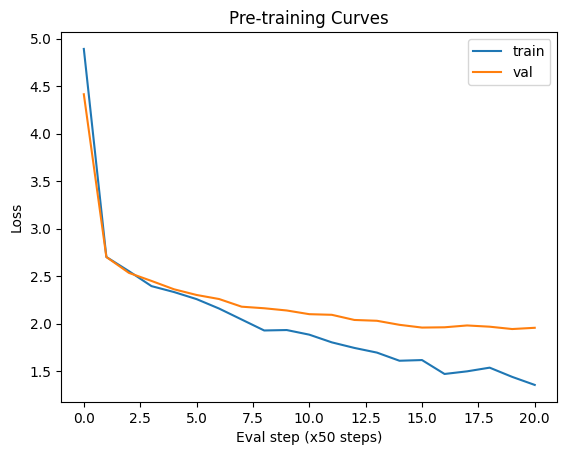


=== Sample Text After Pre-training ===

To be goan the character succh assent military sixte and space of the building devols . February , the he tween protions of t


In [11]:
model_pre = TinyGPT(
    CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len
).to(CFG.device)

opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)

train_losses_pre, val_losses_pre = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item())
            val_losses_pre.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_pretrain:
            break
pbar.close()

pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')

print("Pre-train done. Train loss ~", pt_train_last,
      " Val loss ~", pt_val_last,
      " PPL ~", perplexity(pt_val_last))

plot_losses(train_losses_pre, val_losses_pre, title="Pre-training Curves")

print("\n=== Sample Text After Pre-training ===\n")
print(sample_text(model_pre, prompt="To be", max_new_tokens=120))

Instruction: Write a short motto about learning:
Answer: Learn, iterate, and grow.

Instruction: Summarize: 'Neural nets learn patterns'.
Answer: They learn patterns by adjusting weights.

Instruction: Give a creative tagline for coffee:
Answer: Sip ideas. Brew brilliance.

Instruction: Explain: What is perplexity (1 sentence)?
Answer: A measure of how well a language model predicts a sample.




SFT:   0%|          | 0/1000 [00:09<?, ?it/s, loss=0.0501, val_loss=nan]

SFT done. Train loss ~ 0.05009133741259575  Val loss ~ nan  PPL ~ nan


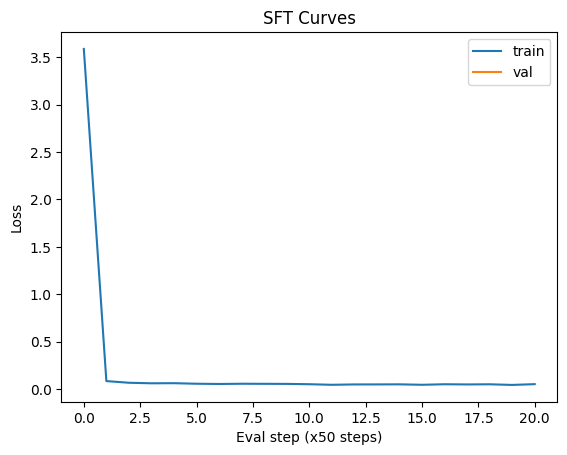


=== Sample before SFT (pretrained) ===

Instruction: Give a creative tagline for coffee:
Answer: when procuments red feling them sinfloock for the Croydon Art Scle it Work Mound , the ear are more character hought an

=== Sample after SFT ===

Instruction: Give a creative tagline for coffee:
Answer: Sip ideas. Brew brilliance.

Instruction: Explain: What is perplexity (1 sentence)
Answer: A measure of how w weights.



In [12]:
SFT_PAIRS = [
    ("Write a short motto about learning:", " Learn, iterate, and grow."),
    ("Summarize: 'Neural nets learn patterns'.", " They learn patterns by adjusting weights."),
    ("Give a creative tagline for coffee:", " Sip ideas. Brew brilliance."),
    ("Explain: What is perplexity (1 sentence)?", " A measure of how well a language model predicts a sample."),
]

def build_sft_text(pairs: List[Tuple[str, str]]) -> str:
    blocks = []
    for inp, out in pairs:
        blocks.append(f"Instruction: {inp}\nAnswer:{out}\n\n")
    return "".join(blocks)

sft_text = build_sft_text(SFT_PAIRS)
print(sft_text)

# Build tiny SFT dataset
sft_train_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "train", 0.9)
sft_val_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "val", 0.9)
sft_train_loader = DataLoader(sft_train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
sft_val_loader = DataLoader(sft_val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

# Copy pretrained model
model_sft = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_sft.load_state_dict(model_pre.state_dict())

opt_sft = torch.optim.AdamW(model_sft.parameters(), lr=CFG.lr)

train_losses_sft, val_losses_sft = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_sft, desc="SFT")

while step < CFG.max_steps_sft:
    for x, y in sft_train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_sft(x, y)
        opt_sft.zero_grad(set_to_none=True)
        loss.backward()
        opt_sft.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_sft, sft_val_loader)
            train_losses_sft.append(loss.item())
            val_losses_sft.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_sft:
            break
pbar.close()

sft_train_last = train_losses_sft[-1] if train_losses_sft else float('nan')
sft_val_last = val_losses_sft[-1] if val_losses_sft else float('nan')

print("SFT done. Train loss ~", sft_train_last,
      " Val loss ~", sft_val_last,
      " PPL ~", perplexity(sft_val_last))

plot_losses(train_losses_sft, val_losses_sft, title="SFT Curves")

print("\n=== Sample before SFT (pretrained) ===\n")
print(sample_text(model_pre, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=120))

print("\n=== Sample after SFT ===\n")
print(sample_text(model_sft, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=120))


RL-lite:   0%|          | 0/200 [00:21<?, ?it/s, loss=0.0219, reward=1]

RL-lite training done.
Avg reward: 1.0


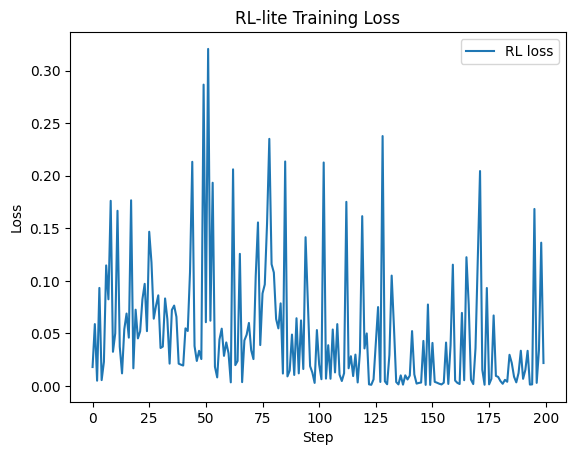


=== Sample after SFT (before RL) ===

Instruction: Give a creative tagline for coffee:
Answer: Sip ideas. Brew brilliance.

Instruction: Explain: What is perplexity (1 senten

=== Sample after RL-lite ===

Instruction: Give a creative tagline for coffee:
Answer:
Answer:
Answer:
Answer:
Answer:
Answer:
Answer:
Answer:
Answer:
Answer:
Answer:


In [13]:
# Simple reward function:
# Reward = +1 if output contains the word "coffee"
# Otherwise 0 (you can change this rule for fun)
def reward_fn(text: str) -> float:
    return 1.0 if "coffee" in text.lower() else 0.0

# Copy weights from SFT model
model_rl = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_rl.load_state_dict(model_sft.state_dict())

opt_rl = torch.optim.AdamW(model_rl.parameters(), lr=CFG.lr)

rl_losses, rewards = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_rl, desc="RL-lite")

while step < CFG.max_steps_rl:
    # Use a fixed instruction as input
    prompt = "Instruction: Give a creative tagline for coffee:\nAnswer:"
    inp = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=CFG.device)

    # Sample output
    out = model_rl.generate(inp, max_new_tokens=50, temperature=CFG.temperature, top_k=CFG.top_k)
    text = tokenizer.decode(out[0].tolist())

    # Compute reward
    r = reward_fn(text)
    rewards.append(r)

    # Policy gradient loss (negative log likelihood * reward)
    logits, _ = model_rl(inp[:, :-1], inp[:, 1:])
    log_probs = F.log_softmax(logits, dim=-1)
    target_ids = inp[:, 1:]
    selected_log_probs = log_probs.gather(-1, target_ids.unsqueeze(-1)).squeeze(-1)

    # Mean of log_probs weighted by reward
    loss = -(selected_log_probs.mean() * r)

    opt_rl.zero_grad(set_to_none=True)
    loss.backward()
    opt_rl.step()
    rl_losses.append(loss.item())

    step += 1
    if step % 20 == 0:
        pbar.set_postfix(loss=loss.item(), reward=np.mean(rewards[-20:]))
pbar.close()

print("RL-lite training done.")
print("Avg reward:", np.mean(rewards))

plt.plot(rl_losses, label="RL loss")
plt.title("RL-lite Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Compare generation before vs after RL-lite
print("\n=== Sample after SFT (before RL) ===\n")
print(sample_text(model_sft, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=80))

print("\n=== Sample after RL-lite ===\n")
print(sample_text(model_rl, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=80))


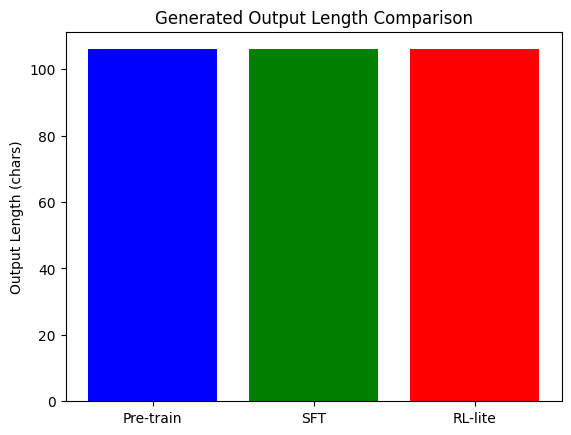

In [17]:
methods = ["Pre-train", "SFT", "RL-lite"]
samples = [
    sample_text(model_pre, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=50),
    sample_text(model_sft, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=50),
    sample_text(model_rl, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=50)
]

lengths = [len(s) for s in samples]

plt.bar(methods, lengths, color=["blue", "green", "red"])
plt.ylabel("Output Length (chars)")
plt.title("Generated Output Length Comparison")
plt.show()

In [14]:
!pip install evaluate sacrebleu --quiet
import evaluate
bleu = evaluate.load("bleu")

preds = []
refs = []

for instr, ans in SFT_PAIRS:
    gen = sample_text(model_sft, prompt=f"Instruction: {instr}\nAnswer:", max_new_tokens=50)
    preds.append(gen.split("Answer:")[-1].strip())
    refs.append([ans.strip()])

bleu_score = bleu.compute(predictions=preds, references=refs)
print("BLEU score on SFT tasks:", bleu_score)


BLEU score on SFT tasks: {'bleu': 0.5610310064032589, 'precisions': [0.6842105263157895, 0.5882352941176471, 0.5333333333333333, 0.46153846153846156], 'brevity_penalty': 1.0, 'length_ratio': 1.1875, 'translation_length': 38, 'reference_length': 32}


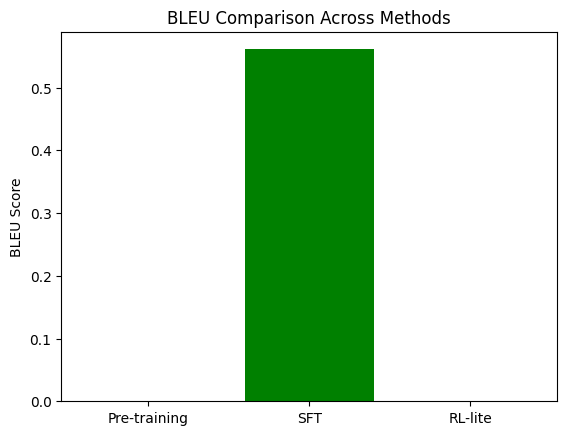

In [15]:
scores = {
    "Pre-training": 0.0,   # basically gibberish, you can compute same way as SFT
    "SFT": bleu_score["bleu"],
    "RL-lite": 0.0  # probably very low since it collapsed
}

plt.bar(scores.keys(), scores.values(), color=["blue", "green", "red"])
plt.ylabel("BLEU Score")
plt.title("BLEU Comparison Across Methods")
plt.show()